In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import gdown

# File ID from the Google Drive link
file_id = '1-VfCsodMGFoJRJmJI1ohw4t6MBRlzA6m'
# URL to download
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file to a specific path
output_path = '/content/your_file.zip'
gdown.download(url, output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-VfCsodMGFoJRJmJI1ohw4t6MBRlzA6m
From (redirected): https://drive.google.com/uc?id=1-VfCsodMGFoJRJmJI1ohw4t6MBRlzA6m&confirm=t&uuid=433561b4-690b-4952-bb00-411ddd58932e
To: /content/your_file.zip
100%|██████████| 319M/319M [00:06<00:00, 51.4MB/s]


'/content/your_file.zip'

In [3]:
import zipfile

# Path to the ZIP file
zip_path = '/content/your_file.zip'
# Folder to extract the contents
extract_path = '/content/extracted_folder'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted successfully!")


Files extracted successfully!


In [4]:
import pandas as pd
pd.read_csv("/content/extracted_folder/driving_log.csv").head()

,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_499.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_499.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_499.jpg,-0.3,0.3515136,0,13.42
0,C:\Users\91920\car data\IMG\center_2024_07_19_...,C:\Users\91920\car data\IMG\left_2024_07_19_02...,C:\Users\91920\car data\IMG\right_2024_07_19_0...,-0.5,0.587964,0,13.70049
1,C:\Users\91920\car data\IMG\center_2024_07_19_...,C:\Users\91920\car data\IMG\left_2024_07_19_02...,C:\Users\91920\car data\IMG\right_2024_07_19_0...,0.0,0.761710,0,14.34658
2,C:\Users\91920\car data\IMG\center_2024_07_19_...,C:\Users\91920\car data\IMG\left_2024_07_19_02...,C:\Users\91920\car data\IMG\right_2024_07_19_0...,0.0,1.000000,0,14.99776
3,C:\Users\91920\car data\IMG\center_2024_07_19_...,C:\Users\91920\car data\IMG\left_2024_07_19_02...,C:\Users\91920\car data\IMG\right_2024_07_19_0...,0.0,1.000000,0,15.73758
4,C:\Users\91920\car data\IMG\center_2024_07_19_...,C:\Users\91920\car data\IMG\left_2024_07_19_02...,C:\Users\91920\car data\IMG\right_2024_07_19_0...,0.0,1.000000,0,16.57924


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense,Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import random
import ntpath
import pandas as pd


In [6]:
data_f = "extracted_folder"
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(data_f, "driving_log.csv"), names=columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_499.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_499.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_499.jpg,-0.3,0.351514,0,13.42000
1,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_571.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_571.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_571.jpg,-0.5,0.587964,0,13.70049
2,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_643.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_643.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_643.jpg,0.0,0.761710,0,14.34658
3,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_715.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_715.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_715.jpg,0.0,1.000000,0,14.99776
4,C:\Users\91920\car data\IMG\center_2024_07_19_02_01_28_783.jpg,C:\Users\91920\car data\IMG\left_2024_07_19_02_01_28_783.jpg,C:\Users\91920\car data\IMG\right_2024_07_19_02_01_28_783.jpg,0.0,1.000000,0,15.73758


We can see we have this much extra in path - "	C:\Users\91920\car data\IMG\" so we will crop it

In [7]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(path_leaf)
data["left"] = data["left"].apply(path_leaf)
data["right"] = data["right"].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_07_19_02_01_28_499.jpg,left_2024_07_19_02_01_28_499.jpg,right_2024_07_19_02_01_28_499.jpg,-0.3,0.351514,0,13.42000
1,center_2024_07_19_02_01_28_571.jpg,left_2024_07_19_02_01_28_571.jpg,right_2024_07_19_02_01_28_571.jpg,-0.5,0.587964,0,13.70049
2,center_2024_07_19_02_01_28_643.jpg,left_2024_07_19_02_01_28_643.jpg,right_2024_07_19_02_01_28_643.jpg,0.0,0.761710,0,14.34658
3,center_2024_07_19_02_01_28_715.jpg,left_2024_07_19_02_01_28_715.jpg,right_2024_07_19_02_01_28_715.jpg,0.0,1.000000,0,14.99776
4,center_2024_07_19_02_01_28_783.jpg,left_2024_07_19_02_01_28_783.jpg,right_2024_07_19_02_01_28_783.jpg,0.0,1.000000,0,15.73758


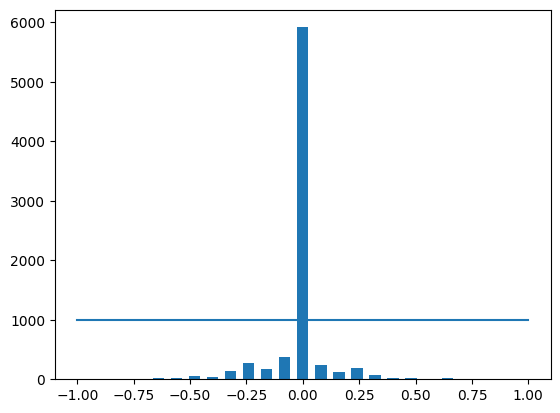

In [8]:
num_bins = 25
samples_per_bin = 1000
hist, bins = np.histogram(data["steering"], num_bins)
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

Unbalanced data we need to remove extra zeros

1.   List item
2.   List item



In [9]:
len(data)

7769

In [10]:
# Remove excess samples
remove_list = []
for j in range(num_bins):
    indices = []
    for i in range(len(data["steering"])):
        if bins[j] <= data["steering"].iloc[i] < bins[j+1]:
            indices.append(i)
    # Shuffle and select excess samples
    indices = shuffle(indices)
    indices_to_remove = indices[samples_per_bin:]
    remove_list.extend(indices_to_remove)

In [11]:
print("removed: ", len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("remaining: ", len(data))

removed:  4916
remaining:  2853


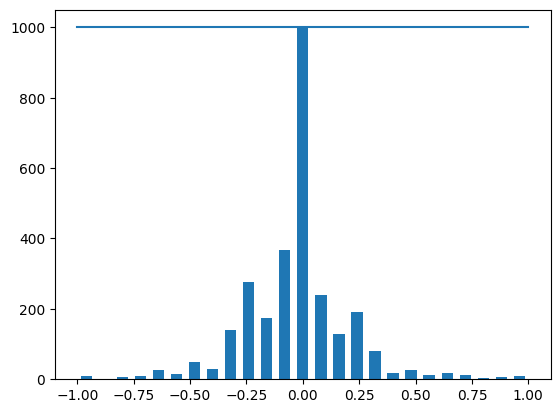

In [12]:
hist, _ = np.histogram(data["steering"], num_bins)  # Fixed typo: np.histogram
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))


In [13]:
def load_img_steering(data_f ,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    left = indexed_data[1]
    right = indexed_data[2]
    image_path.append(os.path.join(data_f, center.strip()))
    steering.append(float(indexed_data[3]))

    #left image
    image_path.append(os.path.join(data_f, left.strip()))
    steering.append(float(indexed_data[3]) + 0.15)

    #right
    image_path.append(os.path.join(data_f, right.strip()))
    steering.append(float(indexed_data[3]) - 0.15)

  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering

In [14]:
image_paths , steerings = load_img_steering(data_f+"/IMG",data)
image_paths

array(['extracted_folder/IMG/center_2024_07_19_02_01_28_499.jpg',
       'extracted_folder/IMG/left_2024_07_19_02_01_28_499.jpg',
       'extracted_folder/IMG/right_2024_07_19_02_01_28_499.jpg', ...,
       'extracted_folder/IMG/center_2024_07_19_02_18_29_430.jpg',
       'extracted_folder/IMG/left_2024_07_19_02_18_29_430.jpg',
       'extracted_folder/IMG/right_2024_07_19_02_18_29_430.jpg'],
      dtype='<U55')

In [15]:
len(steerings)

8559

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=14)
print("Training Samples: {}\nvalid Samples:{}".format(len(X_train), len(X_val)))

Training Samples: 6847
valid Samples:1712


Text(0.5, 1.0, 'Validation set')

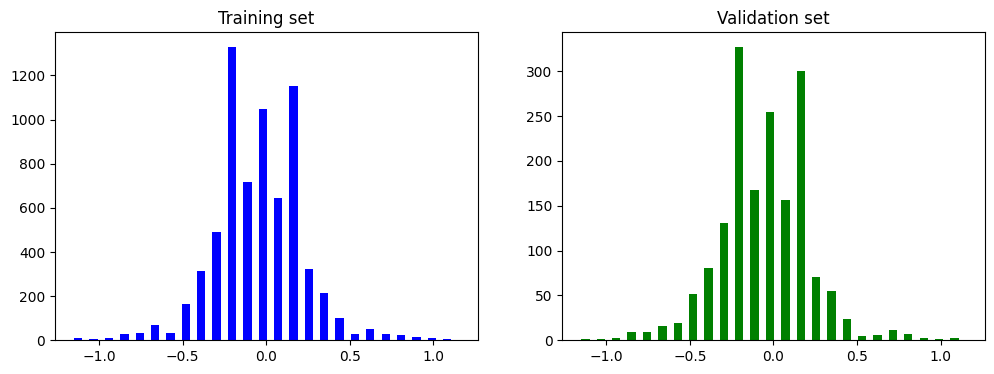

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_val, bins=num_bins, width=0.05, color='green')
axes[1].set_title('Validation set')

Data Augmentation

Text(0.5, 1.0, 'Zoomed Image')

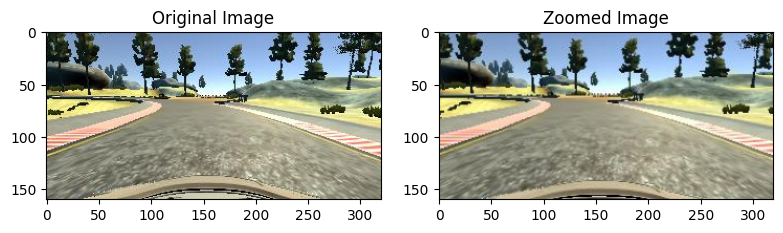

In [18]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.2))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax2.imshow(zoomed_image)
ax2.set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

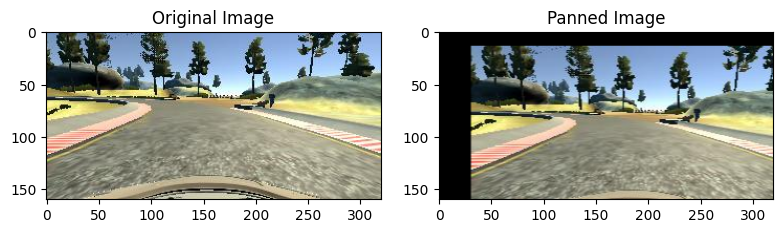

In [19]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
pan_image = pan(original_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax2.imshow(pan_image)
ax2.set_title('Panned Image')

Text(0.5, 1.0, 'Bright Image')

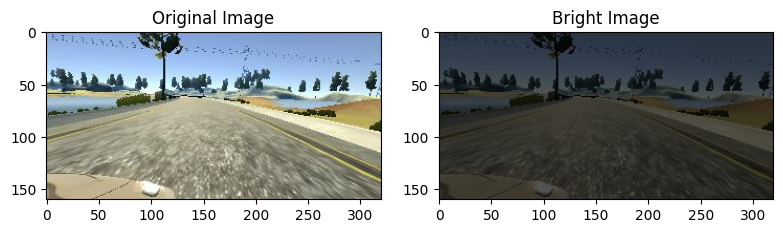

In [20]:
def image_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
bright_image = image_random_brightness(original_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax2.imshow(bright_image)
ax2.set_title('Bright Image')

Text(0.5, 1.0, 'Flipped Image')

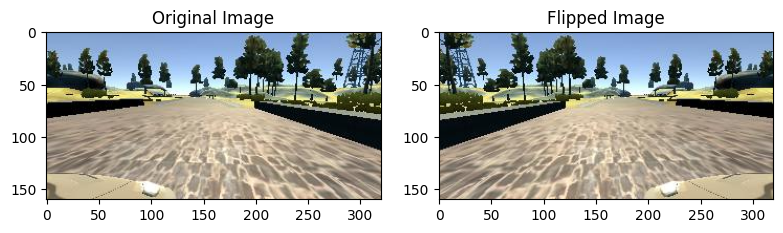

In [21]:
def flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
flipped_image, steering = flip(original_image, steerings[random.randint(0,1000)])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
f.tight_layout()
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax2.imshow(flipped_image)
ax2.set_title('Flipped Image')

In [22]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = flip(image, steering_angle)
  if np.random.rand() < 0.5:
    image = image_random_brightness(image)
  return image, steering_angle


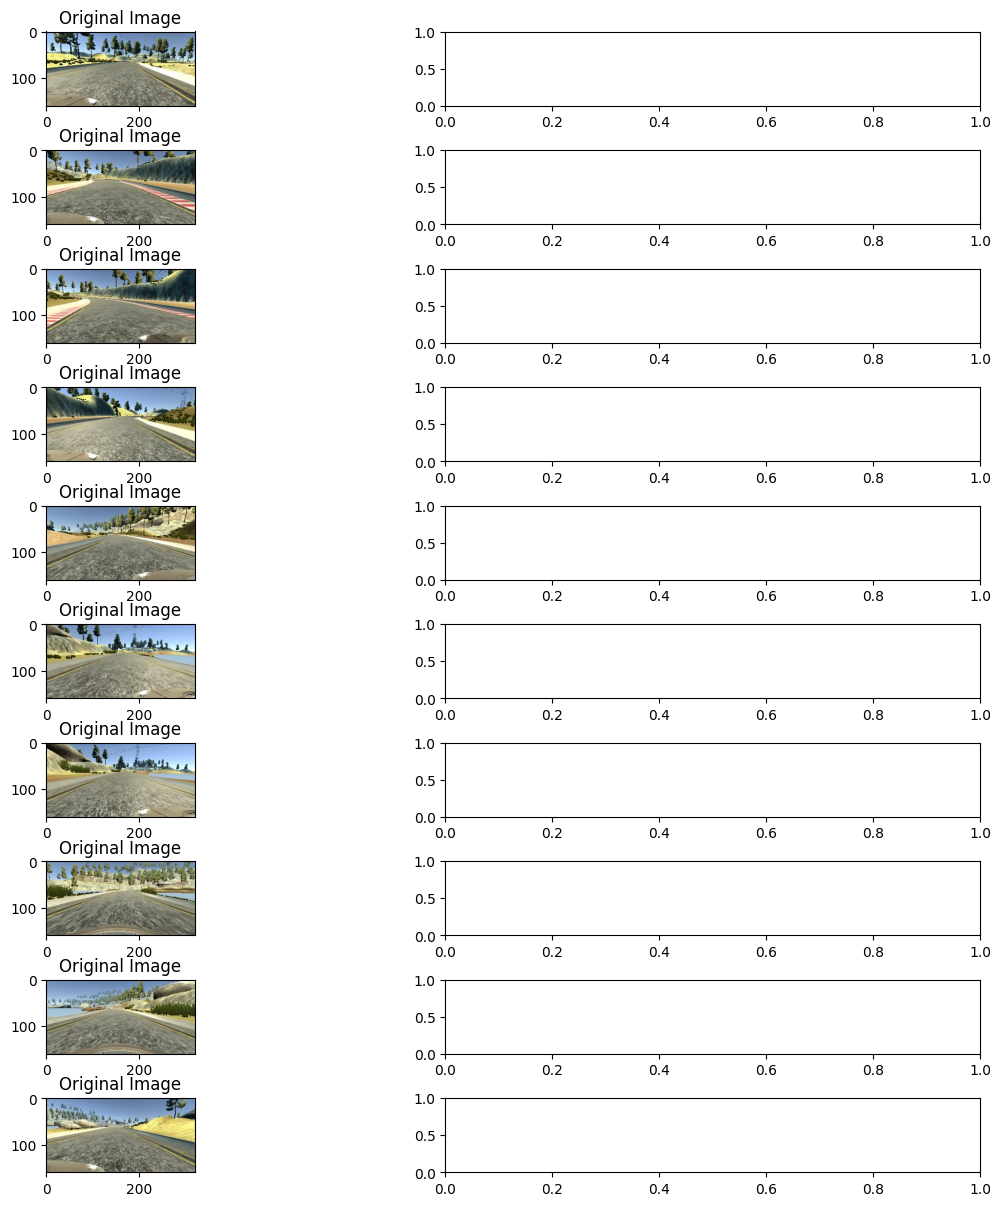

In [23]:

ncols = 2  # Corrected: ncols instead of ncol
nrows = 10

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12)) # Corrected: fig, axes
fig.tight_layout()

for i in range(nrows):
    randnum = random.randint(0, len(image_paths) - 1)
    # image, steering = random_augment(image_paths[randnum], steerings[randnum])  # Assuming you have this function

    original_image = mpimg.imread(image_paths[randnum])
    # augmented_image = mpimg.imread(image)  # Assuming you have the augmented image

    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title("Original Image")

    # axes[i, 1].imshow(augmented_image)
    # axes[i, 1].set_title("Augmented Image")

In [24]:

def img_preprocessing(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = (img/255)
  return img

Text(0.5, 1.0, 'Preprocessed Image')

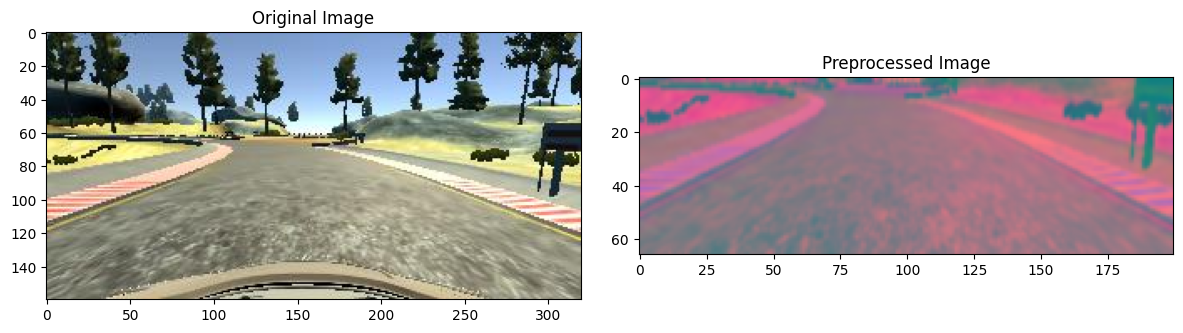

In [25]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocessing(original_image)

f,axs = plt.subplots(1, 2, figsize=(12, 4))
f.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [26]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        img = mpimg.imread(image_paths[random_index])

      img = img_preprocessing(img)
      batch_img.append(img)
      batch_steering.append(steering_ang[random_index])
    yield (np.asarray(batch_img), np.asarray(batch_steering))

We will use nvidia model

In [28]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5),strides= (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5),strides= (2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides = (2, 2), activation='elu'))
  model.add(Conv2D(64,(5,5),activation = "elu"))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dense(50,activation="elu"))
  model.add(Dense(10,activation="elu"))
  model.add(Dense(1))

  optimizer =keras.optimizers.Adam(lr=1e-3)
  model.compile(loss="mse",optimizer=optimizer)

  return model


model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [31]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10, validation_data=batch_generator(X_val, Y_val, 100, 0),
                              steps_per_batch=300, validation_steps=200, verbose=1, shuffle=1)

TypeError: Model.fit_generator() got an unexpected keyword argument 'steps_per_batch'